In [77]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from collections import defaultdict
from scipy.stats import kstest, norm, uniform, beta, expon, truncnorm

from scipy.optimize import brentq

from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import GaussianCopulaSynthesizer
tqdm.pandas()
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings(action='ignore')
import scipy.stats as stats
import seaborn as sns

# import seaborn as sns

In [78]:
data = pd.read_csv('American_Income.csv')

data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [79]:
age_hours_df = data[['age', ' hours-per-week', ' fnlwgt']]

In [80]:
## Necessary Functions
def gmm_cdf(x, gmm):
    """
    Compute the CDF of the GMM at point x.
    
    Parameters:
    - x: Point at which to evaluate the CDF
    - gmm: Fitted GaussianMixture object
    
    Returns:
    - CDF value at point x
    """
    cdf_value = 0
    for weight, mean, covariance in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        cdf_value += weight * stats.norm.cdf(x, mean, np.sqrt(covariance)) 
    return cdf_value[0][0]


def gaussian_inverse_cdf(p_values):
    return norm.ppf(p_values)


def findBestComp(data):
    bic = []
    n_components_range = range(1, 11)
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(data.values.reshape(-1, 1))
        bic.append(gmm.bic(data.values.reshape(-1, 1)))

    optimal_components = n_components_range[np.argmin(bic)]

    return optimal_components



In [81]:
age_components = findBestComp(age_hours_df['age'])

hours_components = findBestComp(age_hours_df[' hours-per-week'])

fnlwgt_components = findBestComp(age_hours_df[' fnlwgt'])

gmm_age = GaussianMixture(n_components=age_components)
gmm_age.fit(age_hours_df['age'].values.reshape(-1, 1))

# Fit a GMM to the 'hours-per-week' column
gmm_hours = GaussianMixture(n_components=hours_components)  
gmm_hours.fit(age_hours_df[' hours-per-week'].values.reshape(-1, 1))

# Fit a GMM to the 'fnlwgt' column
gmm_fnlwgt = GaussianMixture(n_components=fnlwgt_components)  
gmm_fnlwgt.fit(age_hours_df[' fnlwgt'].values.reshape(-1, 1))

GaussianMixture(n_components=6)

In [82]:
GMM_cdf_table = pd.DataFrame()  #initial dataframe to store all the cdf value
GMM_cdf_table['age'] = age_hours_df['age'].apply(lambda x: gmm_cdf(x, gmm_age))

GMM_cdf_table[' hours-per-week'] = age_hours_df[' hours-per-week'].apply(lambda x: gmm_cdf(x, gmm_hours))

GMM_cdf_table[' fnlwgt'] = age_hours_df[' fnlwgt'].apply(lambda x: gmm_cdf(x, gmm_fnlwgt))

In [83]:
GMM_invers_cdf_table = pd.DataFrame()

GMM_invers_cdf_table['age'] = GMM_cdf_table['age'].progress_apply(lambda x: gaussian_inverse_cdf(x))  #

GMM_invers_cdf_table[' hours-per-week'] = GMM_cdf_table[' hours-per-week'].progress_apply(lambda x: gaussian_inverse_cdf(x))

GMM_invers_cdf_table[' fnlwgt'] = GMM_cdf_table[' fnlwgt'].progress_apply(lambda x: gaussian_inverse_cdf(x))

covariance_matrix1 = GMM_invers_cdf_table.cov()

100%|██████████| 32561/32561 [00:02<00:00, 16194.43it/s]


In [84]:
GMM_invers_cdf_table

,age,hours-per-week,fnlwgt
0,0.131724,-0.072699,-1.169204
1,0.814809,-1.904904,-1.119867
2,0.067087,-0.072699,0.489975
3,1.009364,-0.072699,0.672263
4,-0.647353,-0.072699,1.372119
...,...,...,...
32556,-0.729565,-0.742293,0.818615
32557,0.189504,-0.072699,-0.283374
32558,1.288534,-0.072699,-0.308115
32559,-1.238089,-1.440469,0.309073


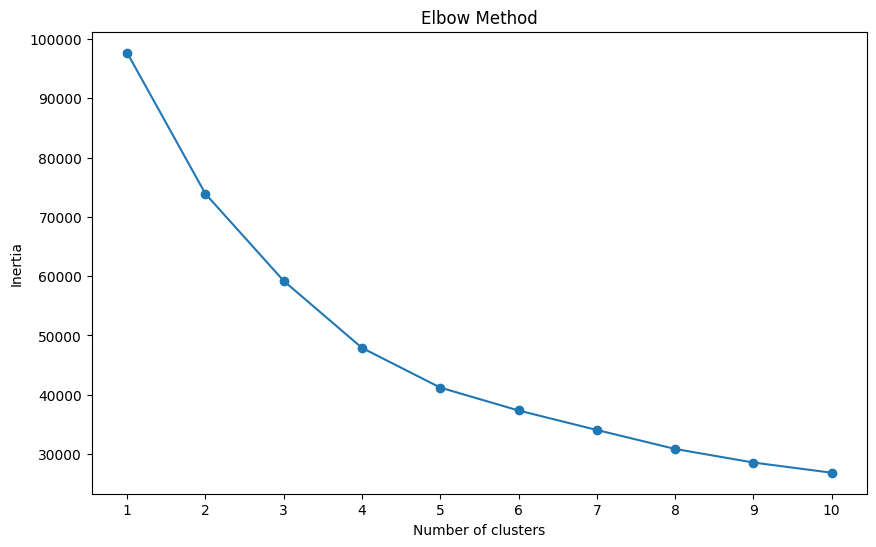

In [85]:
## KMeans Applies Here
scaler = StandardScaler()
scaled_data = scaler.fit_transform(GMM_invers_cdf_table)

# Applying the Elbow method to find the optimal number of clusters
inertia = []
range_of_clusters = range(1, 11)

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_of_clusters)
plt.show()

num_of_cluster = 4

In [86]:
kmeans = KMeans(n_clusters=num_of_cluster, random_state=0)
kmeans.fit(GMM_invers_cdf_table)
labels = kmeans.labels_
GMM_invers_cdf_table['label'] = labels
GMM_invers_cdf_table

,age,hours-per-week,fnlwgt,label
0,0.131724,-0.072699,-1.169204,1
1,0.814809,-1.904904,-1.119867,1
2,0.067087,-0.072699,0.489975,2
3,1.009364,-0.072699,0.672263,1
4,-0.647353,-0.072699,1.372119,2
...,...,...,...,...
32556,-0.729565,-0.742293,0.818615,2
32557,0.189504,-0.072699,-0.283374,1
32558,1.288534,-0.072699,-0.308115,1
32559,-1.238089,-1.440469,0.309073,3


In [87]:
cluster_summary = GMM_invers_cdf_table.groupby('label').agg(['mean', 'median', 'std'])

cluster_summary

age                      hours-per-week                      \
           mean    median       std            mean    median       std   
label                                                                     
0      0.193177  0.189504  0.707047        1.266492  1.045382  0.530077   
1      0.930469  0.814809  0.691972       -0.439671 -0.072699  0.681360   
2     -0.116175 -0.139615  0.721858        0.055751 -0.072699  0.667250   
3     -1.063658 -1.001440  0.632284       -0.670477 -0.072699  0.720863   

         fnlwgt                      
           mean    median       std  
label                                
0     -0.425550 -0.326479  0.785717  
1     -0.459702 -0.382902  0.746516  
2      1.120546  1.027243  0.596553  
3     -0.343329 -0.273578  0.792757

In [88]:
GMM_invers_cdf_table.iloc[:,0:3]

,age,hours-per-week,fnlwgt
0,0.131724,-0.072699,-1.169204
1,0.814809,-1.904904,-1.119867
2,0.067087,-0.072699,0.489975
3,1.009364,-0.072699,0.672263
4,-0.647353,-0.072699,1.372119
...,...,...,...
32556,-0.729565,-0.742293,0.818615
32557,0.189504,-0.072699,-0.283374
32558,1.288534,-0.072699,-0.308115
32559,-1.238089,-1.440469,0.309073


In [89]:
centroids = kmeans.cluster_centers_
centroids

array([[ 0.19238677,  1.26700212, -0.42302046],
       [ 0.93109174, -0.43857077, -0.46166149],
       [-0.11756384,  0.05242516,  1.1184387 ],
       [-1.06464835, -0.67131524, -0.34605072]])

In [90]:
gmm_overall = GaussianMixture(n_components=num_of_cluster, covariance_type='full', random_state=0)

gmm_overall.means_init = centroids ## Initial the means to let the apply components on different cluster

gmm_overall.fit(GMM_invers_cdf_table.iloc[:,0:3])

GaussianMixture(means_init=array([[ 0.19238677,  1.26700212, -0.42302046],
       [ 0.93109174, -0.43857077, -0.46166149],
       [-0.11756384,  0.05242516,  1.1184387 ],
       [-1.06464835, -0.67131524, -0.34605072]]),
                n_components=4, random_state=0)

In [91]:
synthetic_overall = gmm_overall.sample(len(GMM_invers_cdf_table))[0]

column_names = ['age', ' hours-per-week', ' fnlwgt']
synthetic_overall_df = pd.DataFrame(synthetic_overall, columns=column_names)


synthetic_overall_df

covariance_matrix = synthetic_overall_df.cov()

In [92]:
covariance_matrix

,age,hours-per-week,fnlwgt
age,0.998989,0.112326,-0.072917
hours-per-week,0.112326,0.946301,-0.025084
fnlwgt,-0.072917,-0.025084,0.990265


In [93]:
covariance_matrix1

,age,hours-per-week,fnlwgt
age,1.000175,0.125556,-0.070895
hours-per-week,0.125556,0.941501,-0.021516
fnlwgt,-0.070895,-0.021516,0.995499


In [94]:
gmm_age_dict = {
    'weights_': gmm_age.weights_, 
    'means_': gmm_age.means_, 
    'covariances_': gmm_age.covariances_ 
}

gmm_hours_dict = {
    'weights_': gmm_hours.weights_,
    'means_': gmm_hours.means_, 
    'covariances_': gmm_hours.covariances_  
}

gmm_fnlwgt_dict = {
    'weights_': gmm_fnlwgt.weights_,
    'means_': gmm_fnlwgt.means_, 
    'covariances_': gmm_fnlwgt.covariances_  
}

def gmm_cdf_dict(x, gmm):
    """
    Compute the CDF of the GMM at point x using a dictionary to represent the GMM parameters.
    
    Parameters:
    - x: Point at which to evaluate the CDF
    - gmm: Dictionary with GMM parameters
    
    Returns:
    - CDF value at point x
    """
    cdf_value = 0
    for weight, mean, covariance in zip(gmm['weights_'], gmm['means_'], gmm['covariances_']):
        cdf_value += weight * norm.cdf(x, mean, np.sqrt(covariance))
    return cdf_value

def check_cdf_bounds(gmm, bounds, probabilities):
    results = []
    for p in probabilities:
        cdf_lower = gmm_cdf_dict(bounds[0], gmm)
        cdf_upper = gmm_cdf_dict(bounds[1], gmm)
        results.append((p, cdf_lower, cdf_upper, np.sign(cdf_lower - p), np.sign(cdf_upper - p)))
    return results

age_bounds = (synthetic_overall_df['age'].min(), synthetic_overall_df['age'].max())
hours_bounds = (synthetic_overall_df[' hours-per-week'].min(), synthetic_overall_df[' hours-per-week'].max())
fnlwgt_bounds = (synthetic_overall_df[' fnlwgt'].min(), synthetic_overall_df[' fnlwgt'].max())   
probabilities = [0.1, 0.5, 0.9]
age_cdf_check = check_cdf_bounds(gmm_age_dict, age_bounds, probabilities)
hours_cdf_check = check_cdf_bounds(gmm_hours_dict, hours_bounds, probabilities)
fnlwgt_cdf_check = check_cdf_bounds(gmm_fnlwgt_dict, fnlwgt_bounds, probabilities)

(age_cdf_check, hours_cdf_check, fnlwgt_cdf_check)

([(0.1,
   array([[8.09799251e-22]]),
   array([[2.15931109e-17]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.5,
   array([[8.09799251e-22]]),
   array([[2.15931109e-17]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.9,
   array([[8.09799251e-22]]),
   array([[2.15931109e-17]]),
   array([[-1.]]),
   array([[-1.]]))],
 [(0.1,
   array([[1.93186065e-06]]),
   array([[0.00435302]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.5,
   array([[1.93186065e-06]]),
   array([[0.00435302]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.9,
   array([[1.93186065e-06]]),
   array([[0.00435302]]),
   array([[-1.]]),
   array([[-1.]]))],
 [(0.1,
   array([[0.00020827]]),
   array([[0.0002085]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.5,
   array([[0.00020827]]),
   array([[0.0002085]]),
   array([[-1.]]),
   array([[-1.]])),
  (0.9,
   array([[0.00020827]]),
   array([[0.0002085]]),
   array([[-1.]]),
   array([[-1.]]))])

In [95]:
def compute_gmm_bounds(gmm, num_std=3):
    """
    Compute bounds for the GMM based on standard deviations from the mean.
    
    Parameters:
    - gmm: Dictionary with GMM parameters
    - num_std: Number of standard deviations to use for bounds
    
    Returns:
    - A tuple (lower_bound, upper_bound)
    """
    means = gmm['means_'].flatten()
    stds = np.sqrt(gmm['covariances_'].flatten())
    
    lower_bounds = means - num_std * stds
    upper_bounds = means + num_std * stds
    
    lower_bound = min(lower_bounds)
    upper_bound = max(upper_bounds)
    
    return lower_bound, upper_bound

# Compute new bounds for age and hours using the GMM parameters and 3 standard deviations
new_age_bounds = compute_gmm_bounds(gmm_age_dict)
new_hours_bounds = compute_gmm_bounds(gmm_hours_dict)
new_fnlwgt_bounds = compute_gmm_bounds(gmm_fnlwgt_dict)

# Check the new CDF values at the computed bounds
new_age_cdf_check = check_cdf_bounds(gmm_age_dict, new_age_bounds, probabilities)
new_hours_cdf_check = check_cdf_bounds(gmm_hours_dict, new_hours_bounds, probabilities)
new_fnlwgt_cdf_check = check_cdf_bounds(gmm_fnlwgt_dict, new_fnlwgt_bounds, probabilities)

(new_age_cdf_check, new_hours_cdf_check, new_fnlwgt_cdf_check)

([(0.1,
   array([[0.0001267]]),
   array([[0.99993653]]),
   array([[-1.]]),
   array([[1.]])),
  (0.5,
   array([[0.0001267]]),
   array([[0.99993653]]),
   array([[-1.]]),
   array([[1.]])),
  (0.9,
   array([[0.0001267]]),
   array([[0.99993653]]),
   array([[-1.]]),
   array([[1.]]))],
 [(0.1,
   array([[4.76110787e-05]]),
   array([[0.99996761]]),
   array([[-1.]]),
   array([[1.]])),
  (0.5,
   array([[4.76110787e-05]]),
   array([[0.99996761]]),
   array([[-1.]]),
   array([[1.]])),
  (0.9,
   array([[4.76110787e-05]]),
   array([[0.99996761]]),
   array([[-1.]]),
   array([[1.]]))],
 [(0.1,
   array([[2.23248284e-05]]),
   array([[0.99997768]]),
   array([[-1.]]),
   array([[1.]])),
  (0.5,
   array([[2.23248284e-05]]),
   array([[0.99997768]]),
   array([[-1.]]),
   array([[1.]])),
  (0.9,
   array([[2.23248284e-05]]),
   array([[0.99997768]]),
   array([[-1.]]),
   array([[1.]]))])

In [96]:
def inverse_cdf_gmm_age(p):
    lower_bound, upper_bound = new_age_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_age) - p
        f_upper = gmm_cdf(upper_bound, gmm_age) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_age) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure

def inverse_cdf_gmm_hours(p):
    lower_bound, upper_bound = new_hours_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_hours) - p
        f_upper = gmm_cdf(upper_bound, gmm_hours) - p
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_hours) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_fnlwgt(p):
    lower_bound, upper_bound = new_fnlwgt_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_hours) - p
        f_upper = gmm_cdf(upper_bound, gmm_hours) - p
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_fnlwgt) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


F_inv = [inverse_cdf_gmm_age, inverse_cdf_gmm_hours, inverse_cdf_gmm_fnlwgt]

In [97]:
import numpy as np
from scipy.stats import norm

def sample(F_inv, Sigma):
    """
    Sample numerical values from the distribution and covariances of the columns.
    
    Parameters:
    - F_inv: A list of inverse CDF functions for the marginals.
    - Sigma: The covariance matrix.
    
    Returns:
    - A sample vector x in the original space.
    """
    # Step 2: Random n-dimensional Gaussian vector
    n = Sigma.shape[0]
    v = np.random.randn(n)
    
    # Step 3: Cholesky decomposition
    L = np.linalg.cholesky(Sigma)
    
    # Step 4: u ← Lv
    u = L.dot(v)
    
    # Step 5: x ← [F_0^(-1)(Φ(u_0)), F_1^(-1)(Φ(u_1)), ..., F_n^(-1)(Φ(u_n))]
    x = [F_inv_i(norm.cdf(u_i)) for F_inv_i, u_i in zip(F_inv, u)]
    
    return x

In [98]:
num_rows = age_hours_df.shape[0]  # Number of rows you want to generate
synthetic_dataset = [sample(F_inv, covariance_matrix) for _ in tqdm(range(num_rows))]
synthetic_df_full = pd.DataFrame(synthetic_dataset, columns=['age', ' hours-per-week',' fnlwgt'])

  0%|          | 0/32561 [00:00<?, ?it/s]

 46%|████▋     | 15123/32561 [03:55<04:21, 66.63it/s]

Failed to find valid bounds for p=2.5511135303582706e-05 after 5 retries


 76%|███████▌  | 24722/32561 [06:22<01:57, 66.44it/s]

Failed to find valid bounds for p=4.1759686898484996e-05 after 5 retries


 76%|███████▌  | 24785/32561 [06:23<01:59, 65.32it/s]

Failed to find valid bounds for p=1.0986478938047551e-05 after 5 retries


 93%|█████████▎| 30239/32561 [07:47<00:35, 64.90it/s]

Failed to find valid bounds for p=3.9498228173321587e-05 after 5 retries


100%|██████████| 32561/32561 [08:23<00:00, 64.61it/s]


In [99]:
synthetic_df_full.isnull().value_counts()

age     hours-per-week   fnlwgt
False  False            False      32557
       True             False          4
Name: count, dtype: int64

In [100]:
synthetic_df_full[" hours-per-week"].fillna(synthetic_df_full[" hours-per-week"].mean(), inplace= True)

In [101]:
synthetic_df_full[" fnlwgt"].isnull().value_counts()

 fnlwgt
False    32561
Name: count, dtype: int64

In [102]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = age_hours_df)

baseline_quality_report = evaluate_quality(
    age_hours_df,  #real data
    synthetic_df_full, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 67.78it/s]


Overall Quality Score: 95.18%

Properties:
Column Shapes: 91.12%
Column Pair Trends: 99.24%


In [103]:
num_rows = age_hours_df.shape[0]  # Number of rows you want to generate
synthetic_dataset1 = [sample(F_inv, covariance_matrix1) for _ in tqdm(range(num_rows))]
synthetic_df_full1 = pd.DataFrame(synthetic_dataset1, columns=['age', ' hours-per-week',' fnlwgt'])

 88%|████████▊ | 28644/32561 [07:13<00:59, 65.47it/s]

Failed to converge for p=6.322704012645442e-06 with bounds (-101663.60092721373, 1115512.5493563109): f(a) and f(b) must have different signs


100%|██████████| 32561/32561 [08:14<00:00, 65.88it/s]


In [104]:
synthetic_df_full1.isnull().value_counts()

age     hours-per-week   fnlwgt
False  False            False      32560
                        True           1
Name: count, dtype: int64

In [105]:
synthetic_df_full1[" hours-per-week"].fillna(synthetic_df_full1[" hours-per-week"].mean(), inplace= True)
synthetic_df_full1[" fnlwgt"].fillna(synthetic_df_full1[" fnlwgt"].mean(), inplace= True)

In [106]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = age_hours_df)

baseline_quality_report = evaluate_quality(
    age_hours_df,  #real data
    synthetic_df_full1, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00, 68.95it/s]


Overall Quality Score: 95.09%

Properties:
Column Shapes: 91.17%
Column Pair Trends: 99.0%
